In [25]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective,helpers # Difference a. We are using ComplexDynamicsProblem
import matplotlib.pyplot as plt
import json
import os
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm


In [26]:
import sys
print(sys.path[1])

/usr/lib/python311.zip


# Analyze

In [27]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


In [28]:
def load_data(pruned = True, raw = False,topology='5.4',system=1):
    if pruned:
        path = f'../data/results/pruned/{system}/'

    else:
        path = f'../data/results/notpruned/{system}/'
    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            s = s.to_pandas_dataframe()

            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [29]:
topology='5.4'
dfs_all = load_data(pruned = True,topology=topology,system=4)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram

In [30]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_48326/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.1   0.175 0.05  0.025 0.425 0.05  0.125 0.075 0.1   0.15  0.05  0.05
 0.7   0.1   0.225 0.55  0.025 0.15  0.025 0.975 0.125 0.075 0.325 0.025
 0.025 0.05  0.475 0.125 0.625 0.15  0.375 0.075 1.55  0.05  0.5   0.05
 0.95  0.2   0.575 0.1   1.275 0.175 0.275 0.025 0.3   0.35  0.825 0.05
 0.075 0.025 0.075 0.075 0.025 0.3   0.25  0.9   0.05  0.375 1.025 0.25
 0.95  0.275 2.15  0.25  0.725 0.05  1.375 0.725 1.15  0.2   1.3   0.4
 0.525 0.275 0.425 0.575 1.175 0.125 0.025 0.125 0.1   0.125 0.175 0.025
 0.025 0.05  0.075 0.025 0.175 0.125 0.575 0.05  0.525 0.15  0.825 0.075
 0.575 0.1   1.175 0.55  1.2   0.25  1.775 0.725 1.2   0.325 1.325 0.95
 1.525 0.55  1.1   0.875 1.    0.225 0.475 0.475 0.7   0.275 0.025 0.075
 0.3   0.175 0.1   0.025 0.025 0.1   0.05  0.225 0.05  0.225 0.025 0.325
 0.125 0.325 0.175 0.925 0.325 0.7   

systemid  precision  timepoints  energy
5.4       2          2           1          0.350
                                 2          2.600
                                 3          6.725
                                 4         13.350
                                 5         19.325
                                 6         19.875
                                 7         15.900
                                 8         11.000
                                 9          5.400
                                 10         2.600
                                 11         1.475
                                 12         0.750
                                 13         0.400
                                 14         0.100
                                 15         0.050
                                 16         0.025
                                 18         0.050
                                 20         0.025
Name: num_occurrences, dtype: float64

defaultdict(<class 'list'>, {2: [2]})
prec 2 timepoints 2
   energy  num_occurrences
0       1            0.350
1       2            2.600
2       3            6.725
3       4           13.350
4       5           19.325


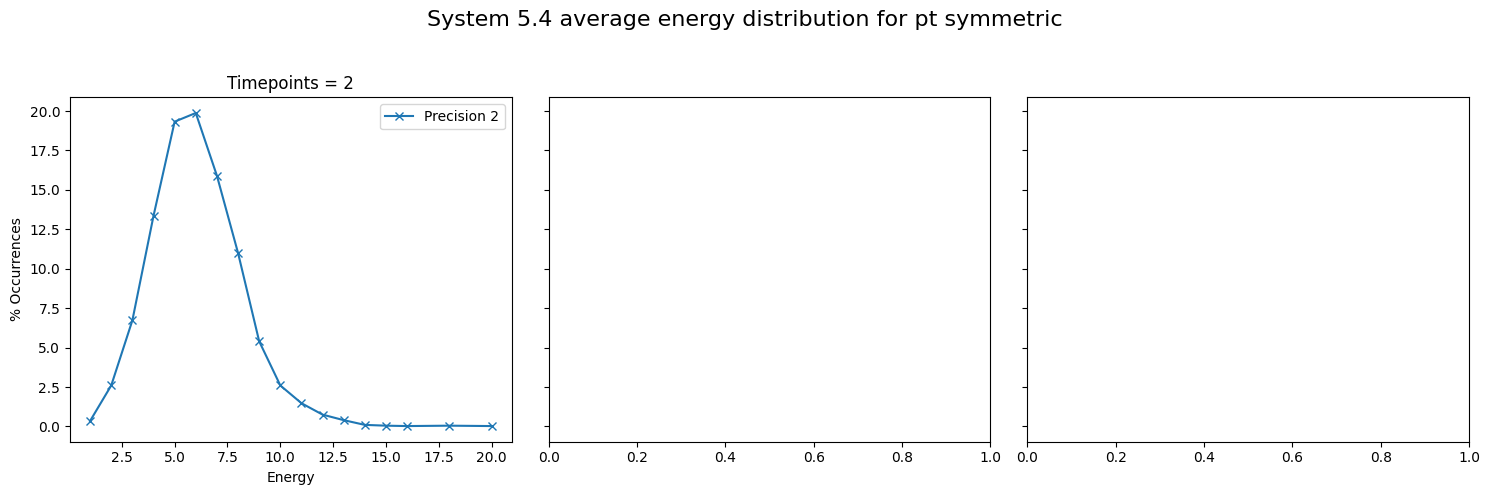

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"System {topology} average energy distribution for pt symmetric", fontsize=16)
markers = ['x','o','v']
prec_time_pairs = get_precision_timepoints_pairs(dfs_all)
timepoint_dict = defaultdict(list)
for timepoint_par in prec_time_pairs:
    timepoint_dict[timepoint_par[1]].append(timepoint_par[0])

print(timepoint_dict)
timepoints = sorted(timepoint_dict.keys())
for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    for p in sorted(timepoint_dict[timepoint]):
        df = dfs_grouped_rounded[topology, p, timepoint].reset_index()
        print(f"prec {p} timepoints {timepoint}")
        print(df.head(5))
        ax.plot(df['energy'], df['num_occurrences'], label=f"Precision {p}", marker=markers[p-2])

    ax.set_xlabel('Energy')
    ax.set_title(f"Timepoints = {timepoint}")
    #ax.set_xlim(0, 200)
    if i == 0:
        ax.set_ylabel('% Occurrences')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('../plots/system54_energy_distribution.pdf')
plt.show()

# Simplification ?

In [20]:
dfs_not_pruned = load_data(pruned=False,precision_range=(2,3))
dfs_not_pruned

TypeError: load_data() got an unexpected keyword argument 'precision_range'

In [86]:
dfs_not_pruned['energy'] = round(dfs_not_pruned['energy'] +0.499) # for displaying in a histogram
dfs_not_pruned = dfs_not_pruned.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_not_pruned.head(3)

NameError: name 'dfs_not_pruned' is not defined

(0.0, 10.0)

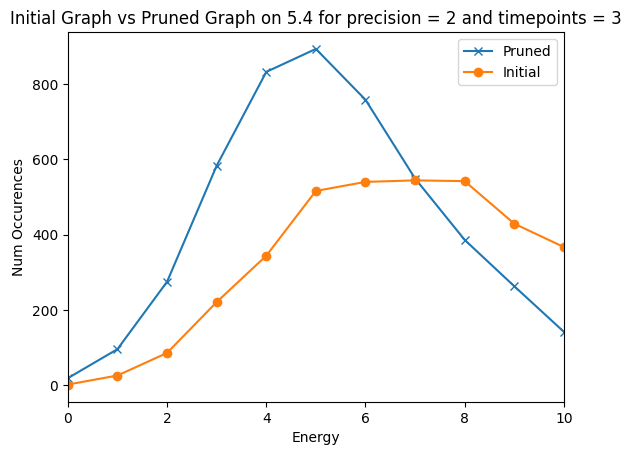

In [75]:
#plt.plot(dfs_not_pruned['energy'],dfs_not_pruned['num_occurrences'],label="Full graph",marker='o')
plt.plot(dfs_grouped['5.4',2,3],label="Pruned",marker='x')
plt.plot(dfs_not_pruned['5.4',2,3],label="Initial",marker='o')

plt.xlabel('Energy')
plt.title("Initial Graph vs Pruned Graph on 5.4 for precision = 2 and timepoints = 3")
plt.ylabel('Num Occurences')
plt.legend()

plt.xlim(0,10)

-more qubits
-pt symmetric eq 12 paper
- include specific machine

3

# Interpret results

In [15]:
system = 4
dfs_data_raw = load_data(raw=True,topology=topology,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']

0      5.4
1      5.4
2      5.4
3      5.4
4      5.4
      ... 
983    5.4
984    5.4
985    5.4
986    5.4
987    5.4
Name: systemid, Length: 3946, dtype: object

-------
maximally entangled qubit
---------
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1. -0.]
 [ 0.  0. -0. -1.]]
---------
array([[-1.00000000e+00+1.11022302e-16j, -1.54074396e-32+1.11022302e-16j,
         2.77555756e-17-4.16333634e-17j,  8.32667268e-17+1.52655666e-16j],
       [-2.77555756e-16+2.08166817e-16j, -1.00000000e+00+1.80411242e-16j,
         2.77555756e-17+5.55111512e-17j,  8.32667268e-17-1.66533454e-16j],
       [-2.31111593e-32-8.32667268e-17j,  1.11022302e-16-2.77555756e-17j,
        -1.00000000e+00-1.52655666e-16j,  2.77555756e-17-2.91433544e-16j],
       [-8.32667268e-17+2.08166817e-16j,  2.08000434e-32-1.52655666e-16j,
        -2.77555756e-17-2.49800181e-16j, -1.00000000e+00-4.16333634e-16j]])


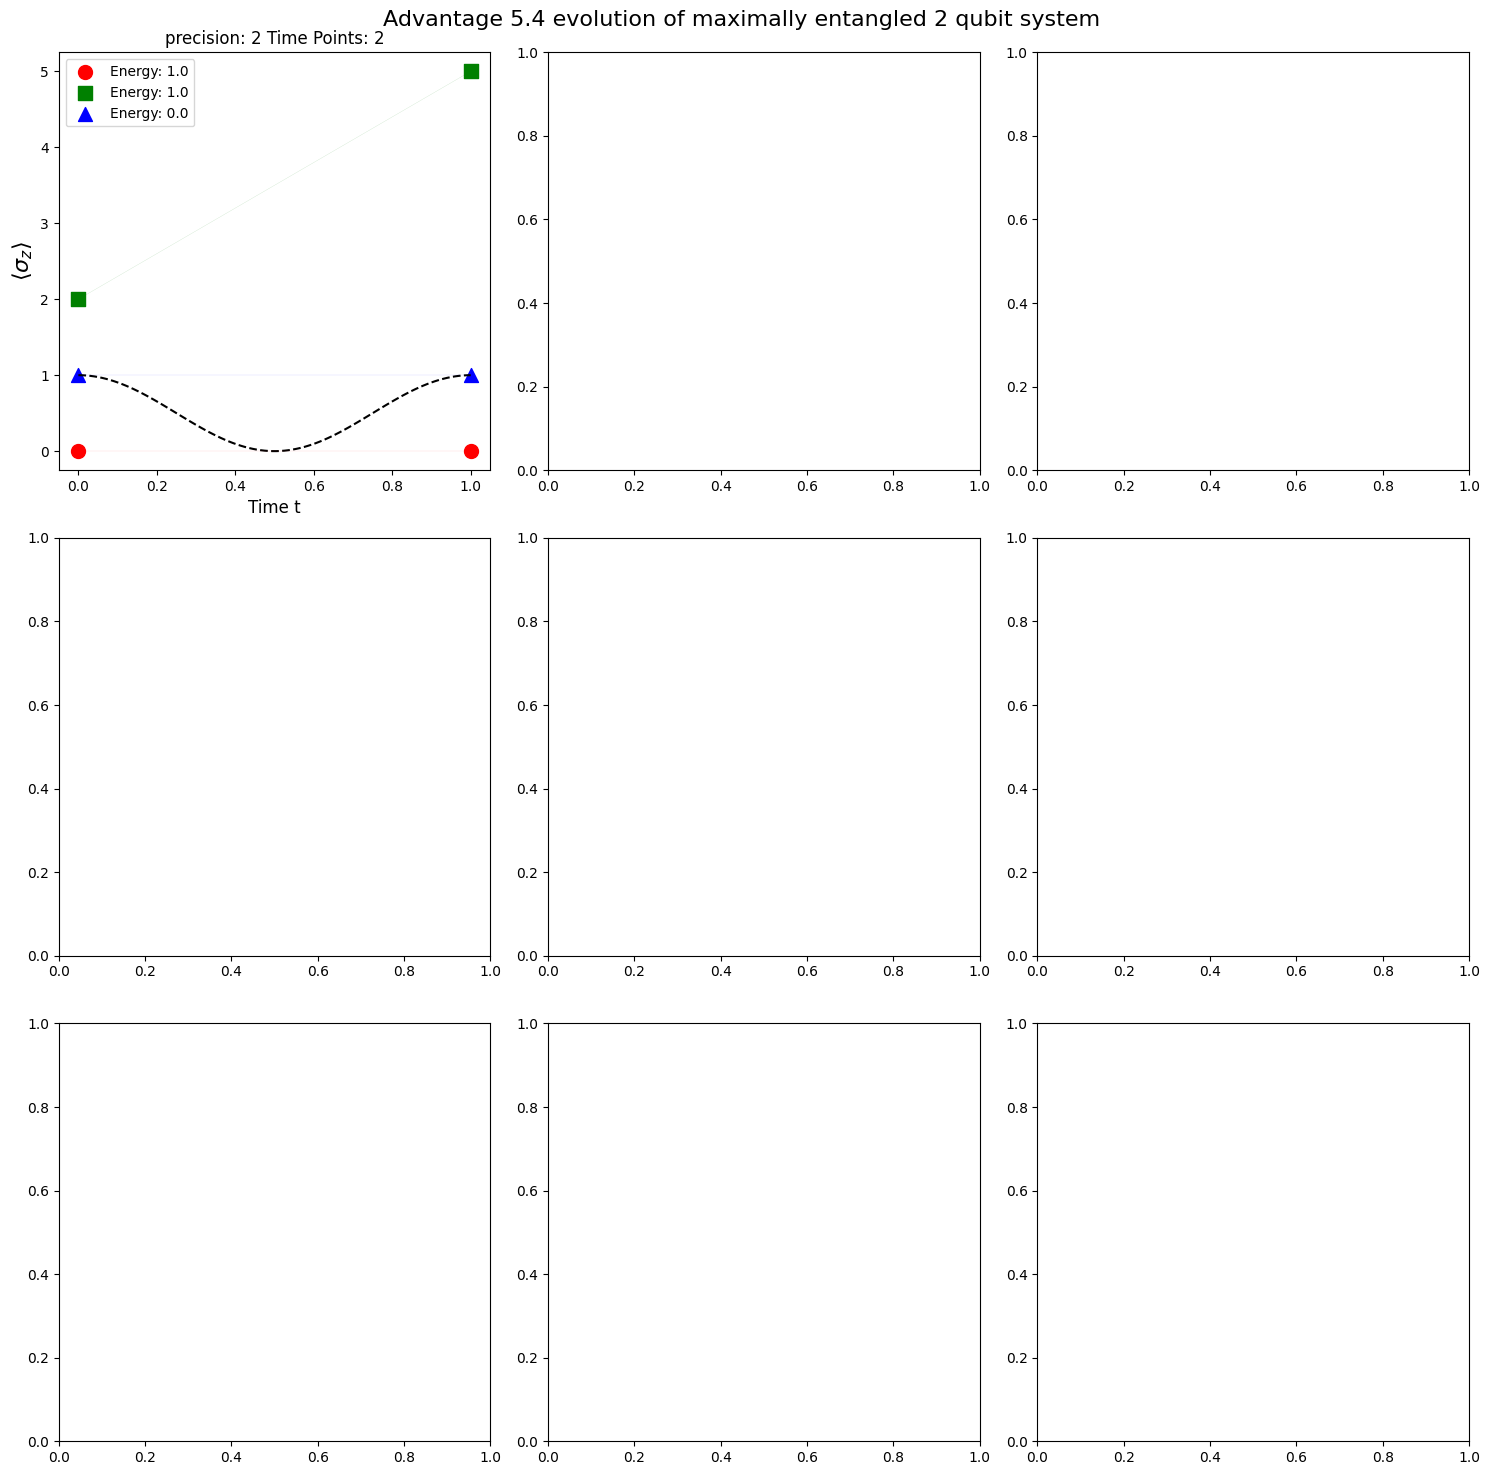

In [24]:
import qutip as qp

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    assert system==4
    instance = helpers.get_instance(system)
    H = instance['H']
    #baseline 
    if system == 4:
        Z1 = qp.tensor(qp.sigmaz(), qp.qeye(2))

        H_qp = qp.Qobj(H,dims=[[2, 2], [2, 2]])

        psi_0 = qp.tensor(qp.basis(2, 0),qp.basis(2,0))

        SZ = np.kron(np.array([[1, 0], [0, -1]]),np.eye(2))
        print(SZ)

    #psi_0 = PSI0
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[Z1]).expect[0]
    ax = axes[i]

    ax.plot(times, baseline, "k--")

    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect = [(state.conj() @ SZ @ state).real for state in vec]
        ax.scatter(problem.times, expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle(f"Advantage {topology} " +rf"evolution of {system_latex_dict[system]} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



In [34]:
sol_dict = dfs_data_raw.iloc[0,:].dropna().to_dict()
sol_dict = {key:int(value) for key,value in sol_dict.items()}

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

prec = 2
timepoints = 4
problem = ComplexDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = PSI0,              # Starting at initial state |0>,
    times=tuple(range(timepoints)),             # With six time points 0,1,2
    num_bits_per_var=prec               # And two bits of precision per variable
)
print(sol_dict)
vec =problem.interpret_sample(sol_dict)

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 1}


In [ ]:
SZ = np.array([[1, 0], [0, -1]])

expect = [(state.conj() @ SZ @ state).real for state in vec]

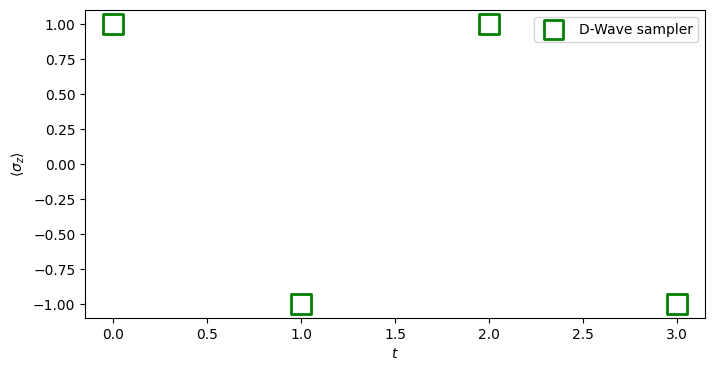

In [36]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

#axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

#axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
#axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(problem.times, expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()